In [71]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

#Python path library support
from pathlib import Path

#python numeric library
import numpy

#python math library
import math

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#make the plots interactive
#%matplotlib inline

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

#jupyter widget support
from ipywidgets import interact
import ipywidgets as widgets

In [55]:
#put in the path to the bin folder
cadet_bin_path = Path(r"C:\Users\kosh_000\cadet_build\CADET\VCPKG\bin")

cadet_path = cadet_bin_path / "cadet-cli.exe"

if cadet_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
else:
    print('CADET could not be found. Please check the bin path')
    
print(cadet_path.as_posix())

CADET was found. Continue to the next step.
C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe


In [56]:
#set this to a directory on your computer where the cadet tutorial files can be saved
cadet_tutorial = Path('F:/temp/cadet_tutorial')
lesson_1 = cadet_tutorial / "lesson_1"
lesson_2 = cadet_tutorial / "lesson_2"
lesson_3 = cadet_tutorial / "lesson_3"
lesson_3.mkdir(exist_ok = True, parents=True)

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/sma_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


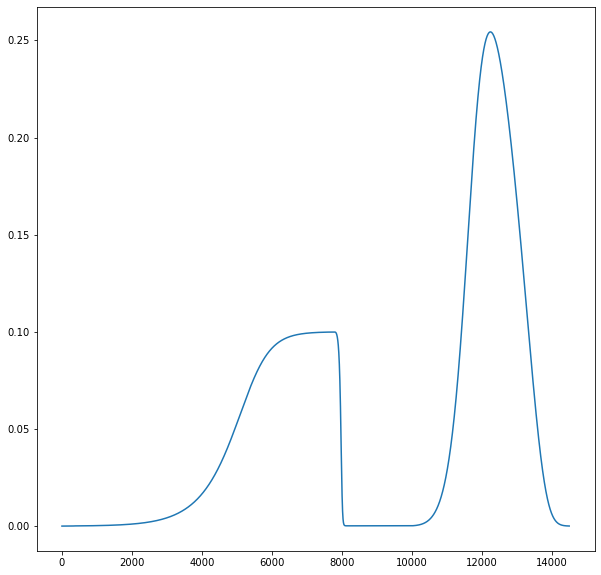

In [57]:
#sma model
sma_example = lesson_3 / "sma_example"
sma_example.mkdir(exist_ok = True)

sma = Cadet()

#load a previous simulation to use as the base for the new one
sma.filename = (lesson_2 / "grm_example" / 'example.h5').as_posix()
sma.load()

#give a filename for where the simulation should be saved
sma.filename = (sma_example / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#change the inlet
sma.root.input.model.unit_000.ncomp = 2

sma.root.input.model.unit_000.sec_000.const_coeff = [180.0,0.1]
sma.root.input.model.unit_000.sec_000.lin_coeff = [0.0,0.0]
sma.root.input.model.unit_000.sec_000.quad_coeff = [0.0,0.0]
sma.root.input.model.unit_000.sec_000.cube_coeff = [0.0,0.0]

sma.root.input.model.unit_000.sec_001.const_coeff = [70.0,0.0]
sma.root.input.model.unit_000.sec_001.lin_coeff = [0.0,0.0]
sma.root.input.model.unit_000.sec_001.quad_coeff = [0.0,0.0]
sma.root.input.model.unit_000.sec_001.cube_coeff = [0.0,0.0]

sma.root.input.model.unit_000.sec_002.const_coeff = [70.0,0.0]
sma.root.input.model.unit_000.sec_002.lin_coeff = [0.08,0.0]
sma.root.input.model.unit_000.sec_002.quad_coeff = [0.0,0.0]
sma.root.input.model.unit_000.sec_002.cube_coeff = [0.0,0.0]


#change the column
sma.root.input.model.unit_001.adsorption_model = 'STERIC_MASS_ACTION'
sma.root.input.model.unit_001.film_diffusion = [2.0E-5, 2.0E-7]
sma.root.input.model.unit_001.init_c = [180.0, 0.0]
sma.root.input.model.unit_001.init_q = [225.0, 0.0]
sma.root.input.model.unit_001.ncomp = 2
sma.root.input.model.unit_001.par_diffusion = [7e-5, 1e-9]
sma.root.input.model.unit_001.par_surfdiffusion = [0.0, 0.0]

sma.root.input.model.unit_001.discretization.nbound = [1,1]

#lower discretization to speed up example for training
sma.root.input.model.unit_001.discretization.ncol = 50
sma.root.input.model.unit_001.discretization.npar = 3

sma.root.input.model.unit_001.adsorption.is_kinetic = 1
sma.root.input.model.unit_001.adsorption.sma_ka = [0.0, 0.3]
sma.root.input.model.unit_001.adsorption.sma_kd = [0.0, 1.5]
sma.root.input.model.unit_001.adsorption.sma_lambda = 225.0
sma.root.input.model.unit_001.adsorption.sma_nu = [0.0, 7.0]
sma.root.input.model.unit_001.adsorption.sma_refc0 = 450.0
sma.root.input.model.unit_001.adsorption.sma_refq = 225.0
sma.root.input.model.unit_001.adsorption.sma_sigma = [0.0, 50.0]

#change the outlet
sma.root.input.model.unit_002.ncomp = 2


#set what values get saved
sma.root.input['return'].unit_000.write_solution_bulk = 0
sma.root.input['return'].unit_000.write_solution_flux = 0
sma.root.input['return'].unit_000.write_solution_inlet = 1
sma.root.input['return'].unit_000.write_solution_outlet = 1
sma.root.input['return'].unit_000.write_solution_particle = 0

sma.root.input['return'].unit_001 = sma.root.input['return'].unit_000
sma.root.input['return'].unit_002 = sma.root.input['return'].unit_000

#set the times that the simulator writes out data for
sma.root.input.solver.user_solution_times = numpy.linspace(0, 14500, 14501)

#solver settings
sma.root.input.solver.sections.section_times = [0.0, 7500.0, 9500.0, 14500.0]

#save the simulation
sma.save()

#run the simulation
data = sma.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    sma.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(sma.root.output.solution.solution_times,
        sma.root.output.solution.unit_002.solution_outlet_comp_001)
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([sma.root.output.solution.solution_times,
                        sma.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((sma_example / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/sma2_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


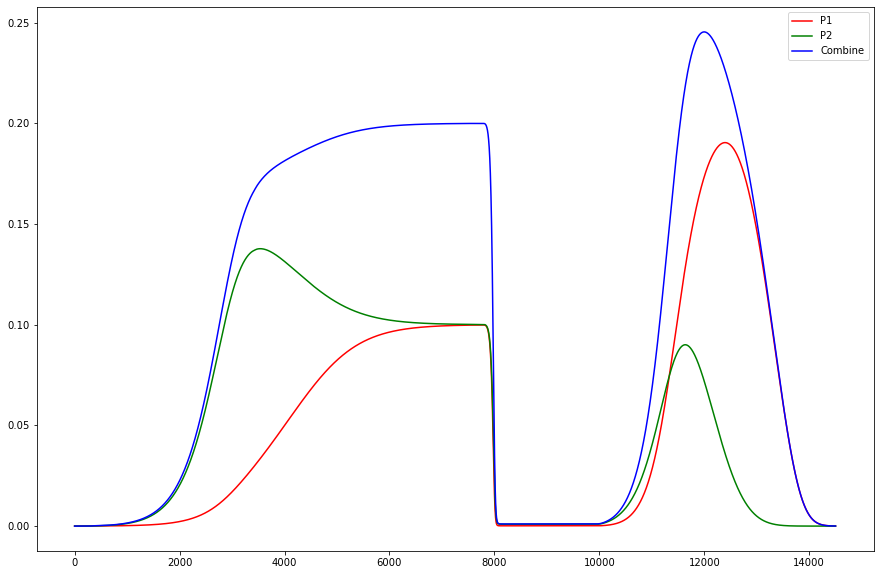

In [58]:
#sma 2-component model
sma2_example = lesson_3 / "sma2_example"
sma2_example.mkdir(exist_ok = True)

sma2 = Cadet()

#load a previous simulation to use as the base for the new one
sma2.filename = (lesson_3 / "sma_example" / 'example.h5').as_posix()
sma2.load()

#give a filename for where the simulation should be saved
sma2.filename = (sma2_example / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#change the inlet
sma2.root.input.model.unit_000.ncomp = 3

sma2.root.input.model.unit_000.sec_000.const_coeff = [180.0,0.1,0.1]
sma2.root.input.model.unit_000.sec_000.lin_coeff = [0.0,0.0,0.0]
sma2.root.input.model.unit_000.sec_000.quad_coeff = [0.0,0.0,0.0]
sma2.root.input.model.unit_000.sec_000.cube_coeff = [0.0,0.0,0.0]

sma2.root.input.model.unit_000.sec_001.const_coeff = [70.0,0.0, 0.0]
sma2.root.input.model.unit_000.sec_001.lin_coeff = [0.0,0.0,0.0]
sma2.root.input.model.unit_000.sec_001.quad_coeff = [0.0,0.0,0.0]
sma2.root.input.model.unit_000.sec_001.cube_coeff = [0.0,0.0,0.0]

sma2.root.input.model.unit_000.sec_002.const_coeff = [70.0,0.0,0.0]
sma2.root.input.model.unit_000.sec_002.lin_coeff = [0.08,0.0, 0.0]
sma2.root.input.model.unit_000.sec_002.quad_coeff = [0.0,0.0,0.0]
sma2.root.input.model.unit_000.sec_002.cube_coeff = [0.0,0.0,0.0]


#change the column
sma2.root.input.model.unit_001.adsorption_model = 'STERIC_MASS_ACTION'
sma2.root.input.model.unit_001.film_diffusion = [2.0E-5, 2.0E-7, 2e-7]
sma2.root.input.model.unit_001.init_c = [180.0, 0.0, 0.0]
sma2.root.input.model.unit_001.init_q = [225.0, 0.0, 0.0]
sma2.root.input.model.unit_001.ncomp = 3
sma2.root.input.model.unit_001.par_diffusion = [7e-5, 1e-9, 1e-9]
sma2.root.input.model.unit_001.par_surfdiffusion = [0.0, 0.0, 0.0]

sma2.root.input.model.unit_001.discretization.nbound = [1,1,1]

#lower discretization to speed up example for training
sma2.root.input.model.unit_001.discretization.ncol = 50
sma2.root.input.model.unit_001.discretization.npar = 3

sma2.root.input.model.unit_001.adsorption.is_kinetic = 1
sma2.root.input.model.unit_001.adsorption.sma_ka = [0.0, 2.0, 2.0]
sma2.root.input.model.unit_001.adsorption.sma_kd = [0.0, 10.0, 10.0]
sma2.root.input.model.unit_001.adsorption.sma_lambda = 225.0
sma2.root.input.model.unit_001.adsorption.sma_nu = [0.0, 7.0, 5.0]
sma2.root.input.model.unit_001.adsorption.sma_refc0 = 450.0
sma2.root.input.model.unit_001.adsorption.sma_refq = 225.0
sma2.root.input.model.unit_001.adsorption.sma_sigma = [0.0, 50.0, 50.0]

#change the outlet
sma2.root.input.model.unit_002.ncomp = 3


#set what values get saved
sma2.root.input['return'].unit_000.write_solution_bulk = 0
sma2.root.input['return'].unit_000.write_solution_flux = 0
sma2.root.input['return'].unit_000.write_solution_inlet = 1
sma2.root.input['return'].unit_000.write_solution_outlet = 1
sma2.root.input['return'].unit_000.write_solution_particle = 0

sma2.root.input['return'].unit_001 = sma2.root.input['return'].unit_000
sma2.root.input['return'].unit_002 = sma2.root.input['return'].unit_000

#set the times that the simulator writes out data for
sma2.root.input.solver.user_solution_times = numpy.linspace(0, 14500, 14501)

#solver settings
sma2.root.input.solver.sections.section_times = [0.0, 7500.0, 9500.0, 14500.0]

#save the simulation
sma2.save()

#run the simulation
data = sma2.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    sma2.load()
    
    #plot the simulation
    plt.figure(figsize=[15,10])
    plt.plot(sma2.root.output.solution.solution_times,
        sma2.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
    plt.plot(sma2.root.output.solution.solution_times,
        sma2.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
    plt.plot(sma2.root.output.solution.solution_times,
        sma2.root.output.solution.unit_002.solution_outlet_comp_001 + sma2.root.output.solution.unit_002.solution_outlet_comp_002, 'b', label='Combine')
    plt.legend()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([sma2.root.output.solution.solution_times,
                        sma2.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((sma2_example / 'example1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([sma2.root.output.solution.solution_times,
                        sma2.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((sma2_example / 'example2.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([sma2.root.output.solution.solution_times,
                        sma2.root.output.solution.unit_002.solution_outlet_comp_001 + sma2.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((sma2_example / 'example1_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/multi_unit_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


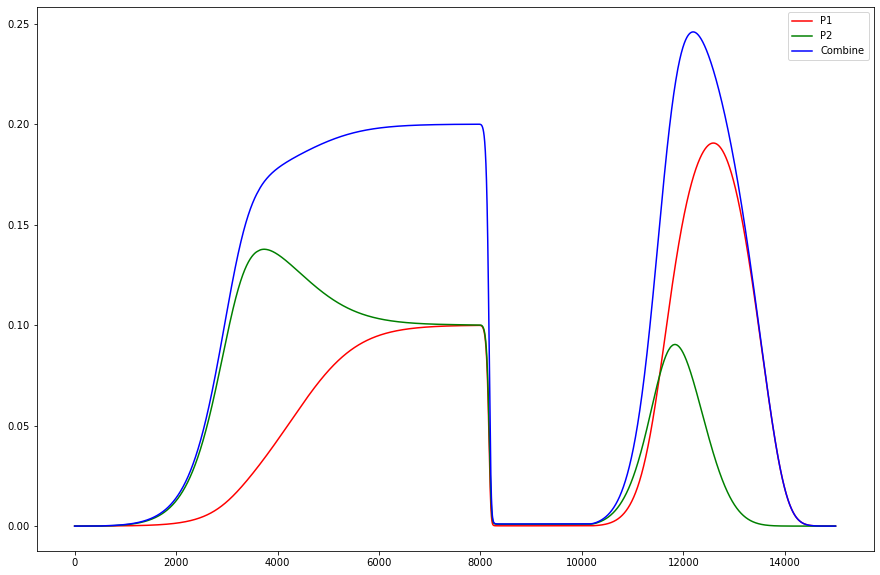

In [59]:
#multiple unit operations
multi_unit_example = lesson_3 / "multi_unit_example"
multi_unit_example.mkdir(exist_ok = True)

multi = Cadet()

#load a previous simulation to use as the base for the new one
multi.filename = (lesson_3 / "sma2_example" / 'example.h5').as_posix()
multi.load()

#give a filename for where the simulation should be saved
multi.filename = (multi_unit_example / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#set the number of unit operations
multi.root.input.model.nunits = 6

#add two new unit operations to represent the tubing going in and out of the column and also add a small cstr as a mixing valve

#for modeling tubing you can use the LUMPED_RATE_MODEL_WITHOUT_PORES
multi.root.input.model.unit_003.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
multi.root.input.model.unit_003.ncomp = 3
multi.root.input.model.unit_003.adsorption_model = 'NONE'
multi.root.input.model.unit_003.init_c = [0.0,0.0,0.0]
multi.root.input.model.unit_003.init_q = [0.0,0.0,0.0]
multi.root.input.model.unit_003.col_dispersion = 2.0e-9
multi.root.input.model.unit_003.col_length = 0.25
multi.root.input.model.unit_003.total_porosity = 1.0
multi.root.input.model.unit_003.velocity = 1
multi.root.input.model.unit_003.cross_section_area = 1.0386890710931253E-5

#discretization column settings
multi.root.input.model.unit_003.discretization.ncol = 40
multi.root.input.model.unit_003.discretization.nbound = [0,0,0]
multi.root.input.model.unit_003.discretization.use_analytic_jacobian = 1
multi.root.input.model.unit_003.discretization.reconstruction = 'WENO'
multi.root.input.model.unit_003.discretization.gs_type = 1
multi.root.input.model.unit_003.discretization.max_krylov = 0
multi.root.input.model.unit_003.discretization.max_restarts = 10
multi.root.input.model.unit_003.discretization.schur_safety = 1.0e-8

multi.root.input.model.unit_003.discretization.weno.boundary_model = 0
multi.root.input.model.unit_003.discretization.weno.weno_eps = 1e-10
multi.root.input.model.unit_003.discretization.weno.weno_order = 3




#make a copy of the tubing as another unit operation
multi.root.input.model.unit_004 = multi.root.input.model.unit_003.copy()


#create the mixer as a CSTR
multi.root.input.model.unit_005.unit_type = 'CSTR'
multi.root.input.model.unit_005.ncomp = 3
multi.root.input.model.unit_005.init_volume = 5e-7
multi.root.input.model.unit_005.init_c = [0.0,0.0,0.0]


#this connects unit 0 to unit 1 and unit 1 to unit 2 with 2.88e-8 m^3/s with all components
multi.root.input.model.connections.switch_000.connections = [0, 5, -1, -1, 2.88e-8,
                                                             5, 3, -1, -1, 2.88e-8,
                                                              3, 1, -1, -1, 2.88e-8,
                                                             1, 4, -1, -1, 2.88e-8,
                                                             4, 2, -1, -1, 2.88e-8]



#set the times that the simulator writes out data for
multi.root.input.solver.user_solution_times = numpy.linspace(0, 15000, 15001)

#solver settings
multi.root.input.solver.sections.section_times = [0.0, 7500.0, 9500.0, 15000.0]

#save the simulation
multi.save()

#run the simulation
data = multi.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    multi.load()
    
    #plot the simulation
    plt.figure(figsize=[15,10])
    plt.plot(multi.root.output.solution.solution_times,
        multi.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
    plt.plot(multi.root.output.solution.solution_times,
        multi.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
    plt.plot(multi.root.output.solution.solution_times,
        multi.root.output.solution.unit_002.solution_outlet_comp_001 + multi.root.output.solution.unit_002.solution_outlet_comp_002, 'b', label='Combine')
    plt.legend()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([multi.root.output.solution.solution_times,
                        multi.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((multi_unit_example / 'example1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([multi.root.output.solution.solution_times,
                        multi.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((multi_unit_example / 'example2.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([multi.root.output.solution.solution_times,
                        multi.root.output.solution.unit_002.solution_outlet_comp_001 + multi.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((multi_unit_example / 'example1_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

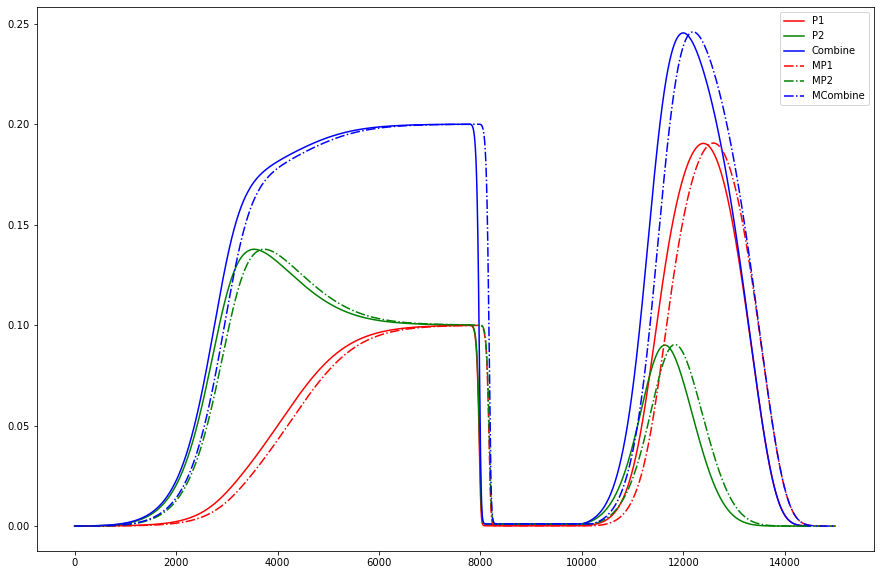

In [60]:
#compare simulations
plt.figure(figsize=[15,10])

plt.plot(sma2.root.output.solution.solution_times,
    sma2.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
plt.plot(sma2.root.output.solution.solution_times,
    sma2.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
plt.plot(sma2.root.output.solution.solution_times,
    sma2.root.output.solution.unit_002.solution_outlet_comp_001 + sma2.root.output.solution.unit_002.solution_outlet_comp_002, 'b', label='Combine')

plt.plot(multi.root.output.solution.solution_times,
    multi.root.output.solution.unit_002.solution_outlet_comp_001, 'r-.', label="MP1")
plt.plot(multi.root.output.solution.solution_times,
    multi.root.output.solution.unit_002.solution_outlet_comp_002, 'g-.', label="MP2")
plt.plot(multi.root.output.solution.solution_times,
    multi.root.output.solution.unit_002.solution_outlet_comp_001 + multi.root.output.solution.unit_002.solution_outlet_comp_002, 'b-.', label='MCombine')

plt.legend()

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/smb_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


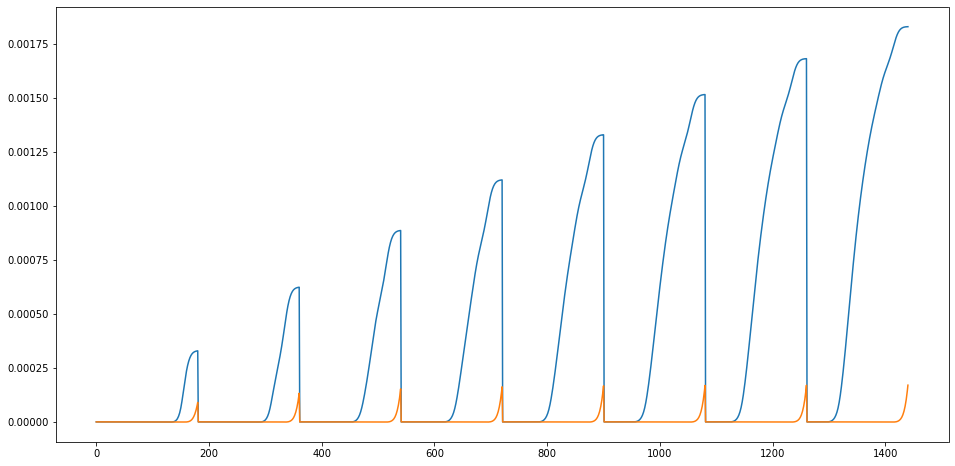

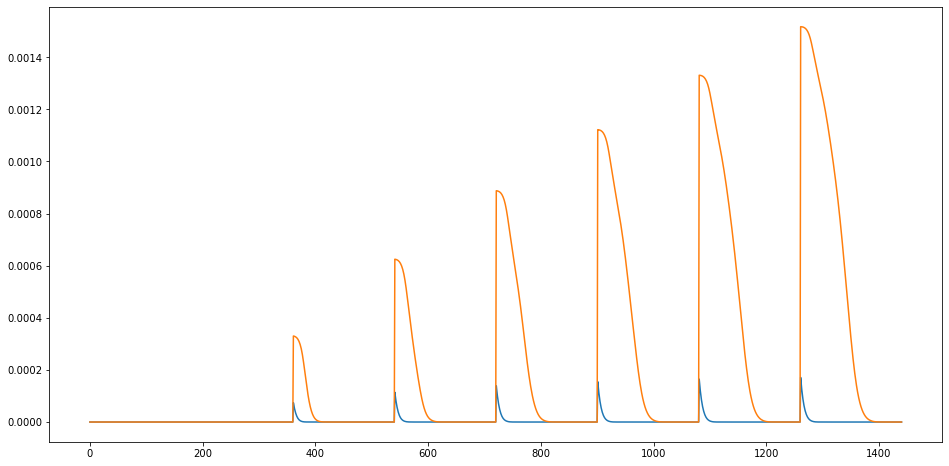

In [93]:
#cyclic systems

#simple model
smb_example = lesson_3 / "smb_example"
smb_example.mkdir(exist_ok = True)

smb = Cadet()

#give a filename for where the simulation should be saved
smb.filename = (smb_example / 'example.h5').as_posix()

#set the number of unit operations
smb.root.input.model.nunits = 8

#nswitches is the number of different ways the units are connected in this simulation
#This is important for cyclic system and more complex setups
smb.root.input.model.connections.nswitches = 4

smb.root.input.model.connections.switch_000.section = 0
smb.root.input.model.connections.switch_000.connections = [4, 5, -1, -1, 7.66e-7,
                                                          5, 6, -1, -1, 7.66e-7,
                                                          6, 7, -1, -1, 8.08e-7,
                                                          7, 4, -1, -1, 8.08e-7,
                                                          0, 4, -1, -1, 0.98e-7,
                                                          1, 6, -1, -1, 1.96e-7,
                                                          4, 2, -1, -1, 1.4e-7,
                                                          6, 3, -1, -1, 1.54e-7]

smb.root.input.model.connections.switch_001.section = 1
smb.root.input.model.connections.switch_001.connections = [4, 5, -1, -1, 8.08e-7,
                                                          5, 6, -1, -1, 7.66e-7,
                                                          6, 7, -1, -1, 7.66e-7,
                                                          7, 4, -1, -1, 8.08e-7,
                                                          0, 5, -1, -1, 0.98e-7,
                                                          1, 7, -1, -1, 1.96e-7,
                                                          5, 2, -1, -1, 1.4e-7,
                                                          7, 3, -1, -1, 1.54e-7]

smb.root.input.model.connections.switch_002.section = 2
smb.root.input.model.connections.switch_002.connections = [4, 5, -1, -1, 8.08e-7,
                                                          5, 6, -1, -1, 8.08e-7,
                                                          6, 7, -1, -1, 7.66e-7,
                                                          7, 4, -1, -1, 7.66e-7,
                                                          0, 6, -1, -1, 0.98e-7,
                                                          1, 4, -1, -1, 1.96e-7,
                                                          6, 2, -1, -1, 1.4e-7,
                                                          4, 3, -1, -1, 1.54e-7]

smb.root.input.model.connections.switch_003.section = 3
smb.root.input.model.connections.switch_003.connections = [4, 5, -1, -1, 7.66e-7,
                                                          5, 6, -1, -1, 8.08e-7,
                                                          6, 7, -1, -1, 8.08e-7,
                                                          7, 4, -1, -1, 7.66e-7,
                                                          0, 7, -1, -1, 0.98e-7,
                                                          1, 5, -1, -1, 1.96e-7,
                                                          7, 2, -1, -1, 1.4e-7,
                                                          5, 3, -1, -1, 1.54e-7]

#create an inlet
smb.root.input.model.unit_000.unit_type = 'INLET'
smb.root.input.model.unit_000.ncomp = 2
smb.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

#const_coeff + lin_coeff*t + quad_coeff*t^2 + cube_coeff*t^3
smb.root.input.model.unit_000.sec_000.const_coeff = [0.003052841918294849,0.003052841918294849]
smb.root.input.model.unit_000.sec_000.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_000.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_000.cube_coeff = [0.0,0.0]

smb.root.input.model.unit_000.sec_001.const_coeff = [0.003052841918294849,0.003052841918294849]
smb.root.input.model.unit_000.sec_001.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_001.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_001.cube_coeff = [0.0,0.0]

smb.root.input.model.unit_000.sec_002.const_coeff = [0.003052841918294849,0.003052841918294849]
smb.root.input.model.unit_000.sec_002.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_002.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_002.cube_coeff = [0.0,0.0]

smb.root.input.model.unit_000.sec_003.const_coeff = [0.003052841918294849,0.003052841918294849]
smb.root.input.model.unit_000.sec_003.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_003.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_000.sec_003.cube_coeff = [0.0,0.0]



smb.root.input.model.unit_001.unit_type = 'INLET'
smb.root.input.model.unit_001.ncomp = 2
smb.root.input.model.unit_001.inlet_type = 'PIECEWISE_CUBIC_POLY'

#const_coeff + lin_coeff*t + quad_coeff*t^2 + cube_coeff*t^3
smb.root.input.model.unit_001.sec_000.const_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_000.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_000.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_000.cube_coeff = [0.0,0.0]

smb.root.input.model.unit_001.sec_001.const_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_001.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_001.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_001.cube_coeff = [0.0,0.0]

smb.root.input.model.unit_001.sec_002.const_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_002.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_002.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_002.cube_coeff = [0.0,0.0]

smb.root.input.model.unit_001.sec_003.const_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_003.lin_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_003.quad_coeff = [0.0,0.0]
smb.root.input.model.unit_001.sec_003.cube_coeff = [0.0,0.0]

#create an outlet
smb.root.input.model.unit_002.ncomp = 2
smb.root.input.model.unit_002.unit_type = 'OUTLET'

smb.root.input.model.unit_003.ncomp = 2
smb.root.input.model.unit_003.unit_type = 'OUTLET'

#create a column
smb.root.input.model.unit_004.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
smb.root.input.model.unit_004.ncomp = 2
smb.root.input.model.unit_004.adsorption_model = 'LINEAR'
smb.root.input.model.unit_004.init_c = [0.0,0.0]
smb.root.input.model.unit_004.init_q = [0.0,0.0]
smb.root.input.model.unit_004.col_dispersion = 3.8148E-20
smb.root.input.model.unit_004.col_length = 0.25
smb.root.input.model.unit_004.total_porosity = 0.83
smb.root.input.model.unit_004.velocity = 1
smb.root.input.model.unit_004.cross_section_area = 3.141592653589793E-4

smb.root.input.model.unit_004.adsorption.is_kinetic = 0
smb.root.input.model.unit_004.adsorption.lin_ka = [5.72, 7.7]
smb.root.input.model.unit_004.adsorption.lin_kd = [1.0, 1.0]

#discretization column settings
smb.root.input.model.unit_004.discretization.ncol = 40
smb.root.input.model.unit_004.discretization.npar = 1
smb.root.input.model.unit_004.discretization.par_disc_type = 'EQUIDISTANT_PAR'
smb.root.input.model.unit_004.discretization.par_disc_vector = [0.0, 0.5, 1.0]
smb.root.input.model.unit_004.discretization.nbound = [1,1]
smb.root.input.model.unit_004.discretization.use_analytic_jacobian = 1
smb.root.input.model.unit_004.discretization.reconstruction = 'WENO'
smb.root.input.model.unit_004.discretization.gs_type = 1
smb.root.input.model.unit_004.discretization.max_krylov = 0
smb.root.input.model.unit_004.discretization.max_restarts = 10
smb.root.input.model.unit_004.discretization.schur_safety = 1.0e-8

smb.root.input.model.unit_004.discretization.weno.boundary_model = 0
smb.root.input.model.unit_004.discretization.weno.weno_eps = 1e-10
smb.root.input.model.unit_004.discretization.weno.weno_order = 3

smb.root.input.model.unit_005 = smb.root.input.model.unit_004.copy()
smb.root.input.model.unit_006 = smb.root.input.model.unit_004.copy()
smb.root.input.model.unit_007 = smb.root.input.model.unit_004.copy()

#set what values get saved
smb.root.input['return'].unit_002.write_solution_bulk = 0
smb.root.input['return'].unit_002.write_solution_flux = 0
smb.root.input['return'].unit_002.write_solution_inlet = 1
smb.root.input['return'].unit_002.write_solution_outlet = 1
smb.root.input['return'].unit_002.write_solution_particle = 0

smb.root.input['return'].unit_003 = smb.root.input['return'].unit_002

#create the columns



#automatically run the simulation in parallel
smb.root.input.solver.nthreads = 0

#set the times that the simulator writes out data for
smb.root.input.solver.user_solution_times = numpy.linspace(0, 1440, 1441)

#set all the tolerances for the time integrator
smb.root.input.solver.time_integrator.abstol = 1e-10
smb.root.input.solver.time_integrator.algtol = 1e-10
smb.root.input.solver.time_integrator.reltol = 1e-6
smb.root.input.solver.time_integrator.init_step_size = 1e-14
smb.root.input.solver.time_integrator.max_steps = 1000000

#solver settings
smb.root.input.solver.sections.nsec = 8
smb.root.input.solver.sections.section_times = [0.0, 180.0, 360.0, 540.0, 720.0,
                                               900.0, 1080.0, 1260.0, 1440.0]
smb.root.input.solver.sections.section_continuity = [0,0,0,0,0,0,0]

#basic solver settings, these values should rarely be changed
smb.root.input.model.solver.gs_type = 1
smb.root.input.model.solver.max_krylov = 0
smb.root.input.model.solver.max_restarts = 10
smb.root.input.model.solver.schur_safety  = 1e-8

#save the simulation
smb.save()

#run the simulation
data = smb.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    smb.load()
    
    #plot the simulation
    plt.figure(figsize=[16,8])
    plt.plot(smb.root.output.solution.solution_times,
        smb.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.plot(smb.root.output.solution.solution_times,
        smb.root.output.solution.unit_002.solution_outlet_comp_001)
    
    
    plt.figure(figsize=[16,8])
    plt.plot(smb.root.output.solution.solution_times,
        smb.root.output.solution.unit_003.solution_outlet_comp_000)
    plt.plot(smb.root.output.solution.solution_times,
        smb.root.output.solution.unit_003.solution_outlet_comp_001)
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([smb.root.output.solution.solution_times,
                        smb.root.output.solution.unit_001.solution_outlet_comp_000]).transpose()
    data.to_csv((smb_example / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

In [86]:
def gen_connections(units, cycle_size, size, step, flows, flows_static):
    temp = []
    connections = list(zip(units, numpy.roll(units,-1), flows))
    io = numpy.roll(units, step)[[0, size*2, size-1, size*3-1]]
    ios = list(zip([0, 1, 2, 3], io))

    for connection in connections:
        temp.append([connection[0], connection[1], -1, -1, connection[2]])
    #inputs
    idx = 0
    for io in ios[:2]:
        temp.append([io[0], io[1], -1, -1, flows_static[idx]])
        idx+=1;
    #outputs
    for io in ios[2:]:
        temp.append([io[1], io[0], -1, -1, flows_static[idx]])
        idx+=1;
    return numpy.array(temp)

def expand_flow(seq, inlet1, inlet2, number):
    "expand the flows for smb, this is more complex since we need link values"
    temp = []
    temp.extend([seq[3] + inlet1] * (number-1))
    temp.append(seq[0])

    temp.extend([seq[0]] * (number-1))
    temp.append(seq[1])

    temp.extend([seq[1] + inlet2] * (number-1))
    temp.append(seq[2])

    temp.extend([seq[2]] * (number-1))
    temp.append(seq[3])

    return temp

In [101]:
def large_smb(cycle_size=4, cycles=2):
    #number of times flows have to be expanded for a 4-zone model
    repeat_size = int(cycle_size/4)

    #simple model
    smb_large_example = lesson_3 / "smb_large_example"
    smb_large_example.mkdir(exist_ok = True)

    smb_large = Cadet()

    #give a filename for where the simulation should be saved
    smb_large.filename = (smb_large_example / 'example.h5').as_posix()


    smb_large.root.input.model.nunits = 4 + cycle_size

    smb_large.root.input.model.solver.gs_type = 1
    smb_large.root.input.model.solver.max_krylov = 0
    smb_large.root.input.model.solver.max_restarts = 0
    smb_large.root.input.model.solver.schur_safety = 1e-8


    #setup connections
    smb_large.root.input.model.connections.nswitches = cycle_size

    units = range(4, 4+cycle_size)

    flows = expand_flow([7.66E-07, 7.66E-07, 8.08E-07, 8.08E-07], 0.98e-7, 1.96e-07, repeat_size)
    flows_static = numpy.array([0.98e-7, 1.96e-7, 1.4e-7, 1.54e-7])

    for i in range(cycle_size):
        smb_large.root.input.model.connections["switch_%03d" % i].section = i
        smb_large.root.input.model.connections["switch_%03d" % i].connections = gen_connections(units, cycle_size, repeat_size, -i, numpy.array(list(numpy.roll(flows, i))), flows_static )

    #setup inlets
    smb_large.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
    smb_large.root.input.model.unit_000.ncomp = 2
    smb_large.root.input.model.unit_000.unit_type = 'INLET'

    for i in range(cycle_size):
        #section
        smb_large.root.input.model.unit_000["sec_%03d" % i].const_coeff = [0.55/180.16, 0.55/180.16]
        smb_large.root.input.model.unit_000["sec_%03d" % i].lin_coeff = [0.0, 0.0]
        smb_large.root.input.model.unit_000["sec_%03d" % i].quad_coeff = [0.0, 0.0]
        smb_large.root.input.model.unit_000["sec_%03d" % i].cube_coeff = [0.0, 0.0]

    smb_large.root.input.model.unit_001.inlet_type = 'PIECEWISE_CUBIC_POLY'
    smb_large.root.input.model.unit_001.ncomp = 2
    smb_large.root.input.model.unit_001.unit_type = 'INLET'

    for i in range(cycle_size):
        #section
        smb_large.root.input.model.unit_001["sec_%03d" % i].const_coeff = [0.0, 0.0]
        smb_large.root.input.model.unit_001["sec_%03d" % i].lin_coeff = [0.0, 0.0]
        smb_large.root.input.model.unit_001["sec_%03d" % i].quad_coeff = [0.0, 0.0]
        smb_large.root.input.model.unit_001["sec_%03d" % i].cube_coeff = [0.0, 0.0]

    #create columns
    for unit in range(4, 4 + cycle_size):

        smb_large.root.input.model["unit_%03d" % unit].unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'

        col = smb_large.root.input.model["unit_%03d" % unit]

        col.ncomp = 2
        col.adsorption_model = 'LINEAR'
        col.init_c = [0.0,0.0]
        col.init_q = [0.0,0.0]
        col.col_dispersion = 3.8148E-20
        col.col_length = 0.25/repeat_size
        col.total_porosity = 0.83
        col.velocity = 1
        col.cross_section_area = 3.141592653589793E-4

        col.adsorption.is_kinetic = 0
        col.adsorption.lin_ka = [5.72, 7.7]
        col.adsorption.lin_kd = [1.0, 1.0]

        col.discretization.gs_type = 1
        col.discretization.max_krylov = 0
        col.discretization.max_restarts = 0
        col.discretization.nbound = [1, 1]
        col.discretization.ncol = max(int(40/repeat_size), 3)
        col.discretization.par_disc_type = 'EQUIDISTANT_PAR'
        col.discretization.par_disc_vector = [0.0, 0.5, 1.0]
        col.discretization.reconstruction = 'WENO'
        col.discretization.schur_safety = 1e-8
        col.discretization.use_analytic_jacobian = 1

        col.discretization.weno.boundary_model = 0
        col.discretization.weno.weno_eps = 1e-12
        col.discretization.weno.weno_order = 3

    #create outlets
    smb_large.root.input.model.unit_002.ncomp = 2
    smb_large.root.input.model.unit_002.unit_type = 'OUTLET'

    smb_large.root.input.model.unit_003.ncomp = 2
    smb_large.root.input.model.unit_003.unit_type = 'OUTLET'

    #create output information

    smb_large.root.input['return'].write_solution_times = 1

    ret = smb_large.root.input['return']

    ret.write_solution_last = 1

    ret.unit_002.write_solution_column = 0
    ret.unit_002.write_solution_column_inlet = 1
    ret.unit_002.write_solution_column_outlet = 1
    ret.unit_002.write_solution_flux = 0
    ret.unit_002.write_solution_particle = 0

    ret.unit_003.write_solution_column = 0
    ret.unit_003.write_solution_column_inlet = 1
    ret.unit_003.write_solution_column_outlet = 1
    ret.unit_003.write_solution_flux = 0
    ret.unit_003.write_solution_particle = 0

    smb_large.root.input.solver.nthreads = 0
    smb_large.root.input.solver.user_solution_times = numpy.linspace(0, cycles*180*4, 1000*cycle_size*cycles)
    smb_large.root.input.solver.sections.nsec = cycle_size*cycles
    smb_large.root.input.solver.sections.section_continuity = [0] * (cycle_size*cycles -1)
    smb_large.root.input.solver.sections.section_times = [float(i) * 180*4.0/cycle_size for i in range(cycle_size*cycles+1)]

    smb_large.root.input.solver.time_integrator.abstol = 1e-10
    smb_large.root.input.solver.time_integrator.algtol = 1e-10
    smb_large.root.input.solver.time_integrator.init_step_size = 1e-14
    smb_large.root.input.solver.time_integrator.max_steps = 1e6
    smb_large.root.input.solver.time_integrator.reltol = 1e-6


    #save the simulation
    smb_large.save()

    #run the simulation
    data = smb_large.run()

    print(data)

    if data.returncode == 0:
        print("Simulation completed successfully")

        #load the data from the simulation so we can view the results
        smb_large.load()

        #plot the simulation
        plt.figure(figsize=[16,8])
        plt.plot(smb_large.root.output.solution.solution_times,
            smb_large.root.output.solution.unit_002.solution_outlet_comp_000)
        plt.plot(smb_large.root.output.solution.solution_times,
            smb_large.root.output.solution.unit_002.solution_outlet_comp_001)


        plt.figure(figsize=[16,8])
        plt.plot(smb_large.root.output.solution.solution_times,
            smb_large.root.output.solution.unit_003.solution_outlet_comp_000)
        plt.plot(smb_large.root.output.solution.solution_times,
            smb_large.root.output.solution.unit_003.solution_outlet_comp_001)

        #write the chromatogram data out to a csv file
        data = pandas.DataFrame([smb_large.root.output.solution.solution_times,
                            smb_large.root.output.solution.unit_001.solution_outlet_comp_000]).transpose()
        data.to_csv((smb_large_example / 'example.csv').as_posix(), index=False, header=False)

    else:
        print("Simulation failed")

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/smb_large_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


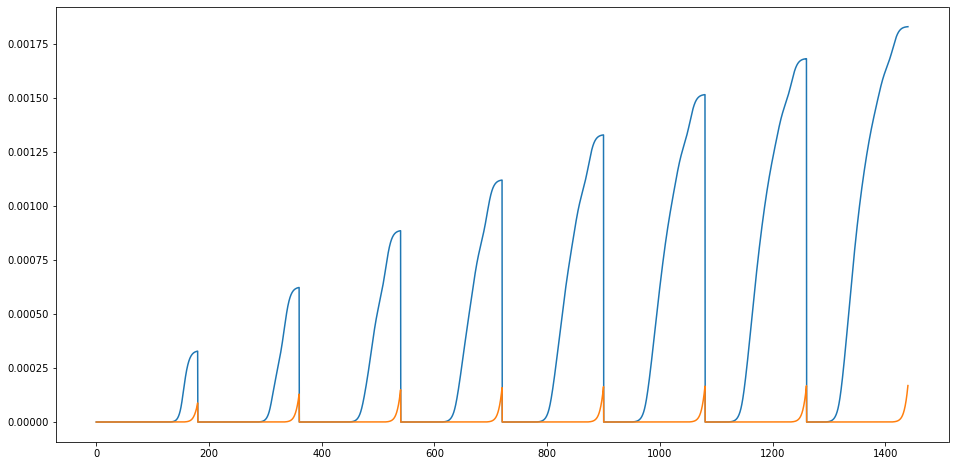

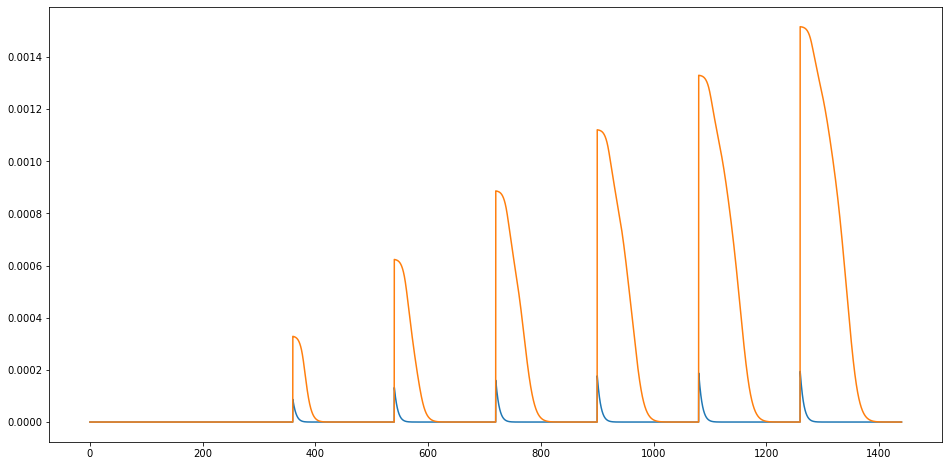

In [102]:
large_smb(4,2)

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/smb_large_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


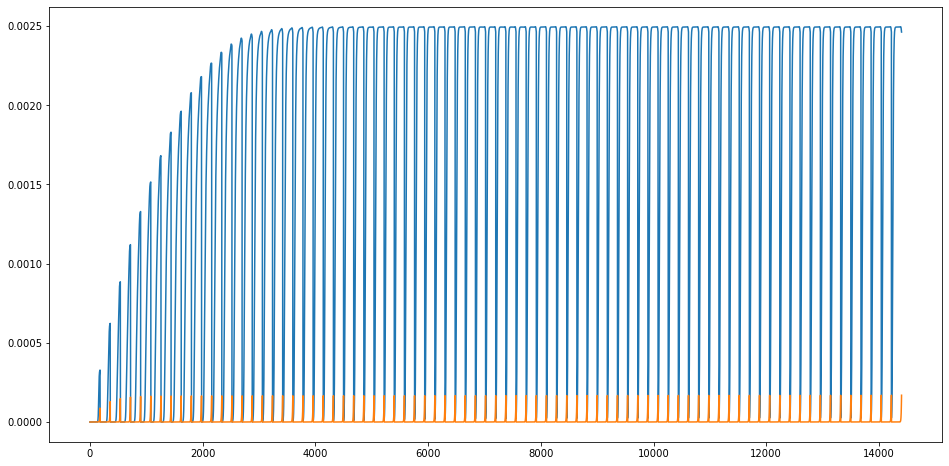

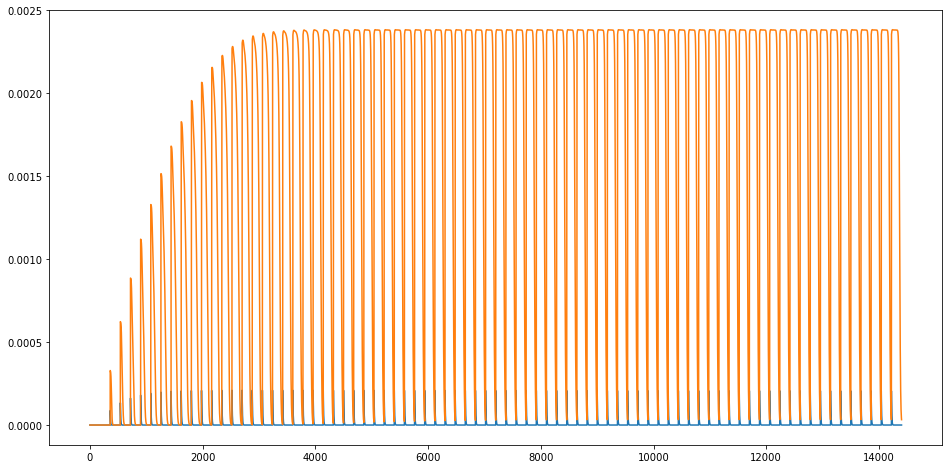

In [103]:
large_smb(4,20)

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/smb_large_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


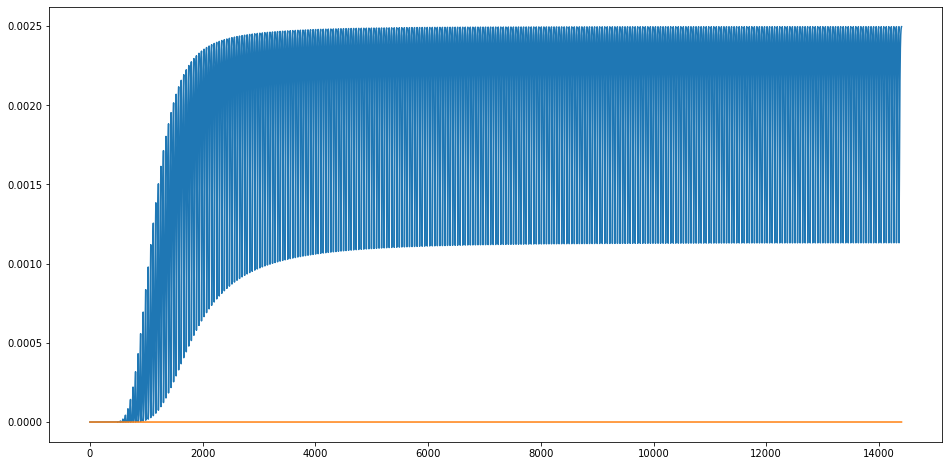

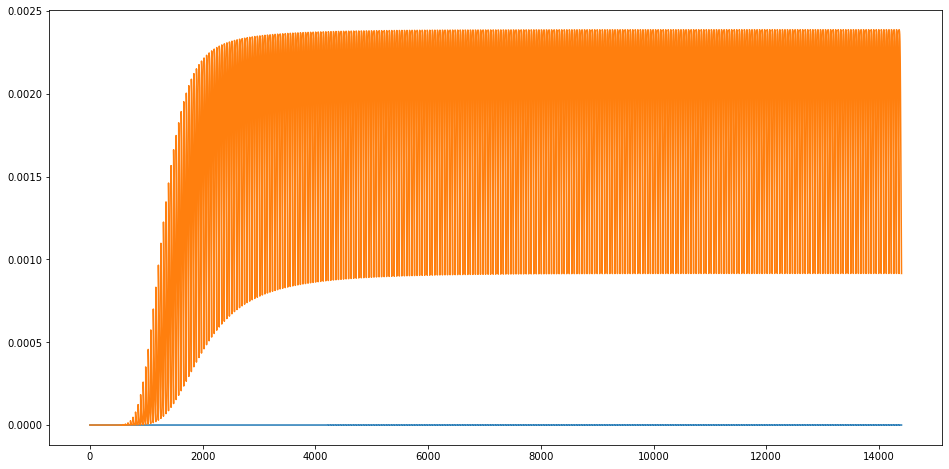

In [104]:
large_smb(16, 20)

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/smb_large_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


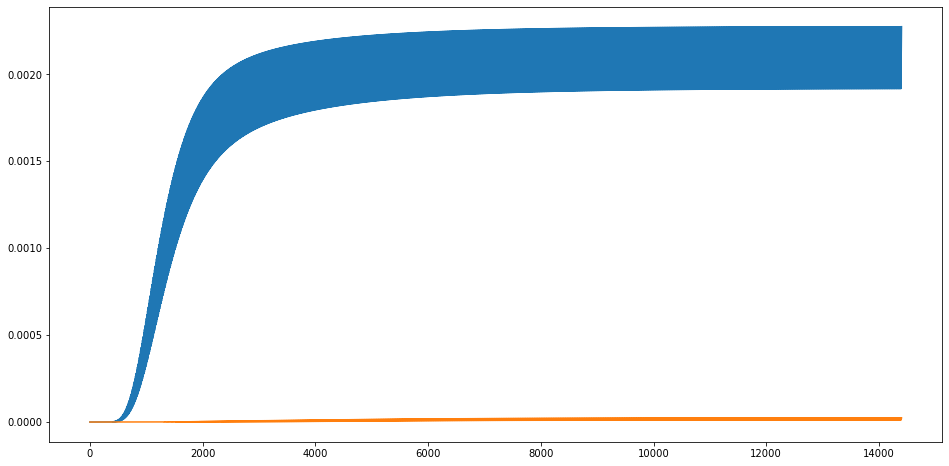

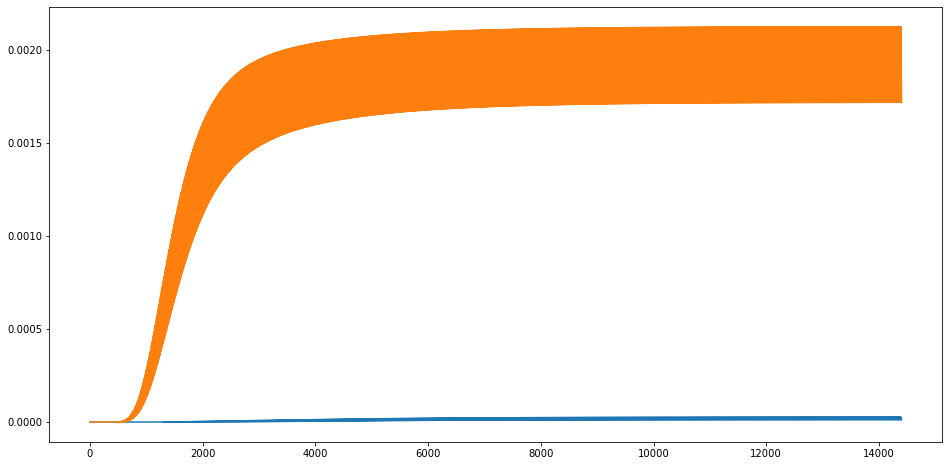

In [105]:
large_smb(64, 20)

In [ ]:
large_smb(256, 20)

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_3/smb_large_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully
